<center><strong><font size=+3>Calibration of visibilities in Jupyter</font></center>
<br><center><strong><font size=+1>Calibration products from the H1C_IDR2.2 makeflow pipeline</font></strong>
<br><br>
</center>
<center><strong><font size=+2>Matyas Molnar</font><br></strong></center>
<br><center><strong><font size=+1>8th January 2020</font></strong></center>

In [1]:
import glob
import os
import sys
from copy import deepcopy

import numpy as np
from matplotlib import pyplot as plt

from hera_cal.abscal import match_times
from hera_cal.apply_cal import calibrate_in_place
from hera_cal.io import HERAData, HERACal
from hera_cal.redcal import get_reds, redcal_argparser, redcal_run
from hera_cal.utils import split_bl

from cal_utils import plot_vis, waterfall_column

In [2]:
%matplotlib inline

In [3]:
JD = 2458098.43869

In [4]:
analysis_folder = '/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/{}'.format(int(JD))
raw_data_fn = 'zen.{}.HH.uvh5'.format(JD)

hera_pkgs = '/users/heramgr/hera_software/'
if not os.path.exists(analysis_folder): # working locally
    analysis_folder = '/Users/matyasmolnar/Downloads/HERA_Data/hc_analysis/sample_calib'
    hera_pkgs = '/Users/matyasmolnar/Downloads/HERA_Data/hera_packages/'

### Reading raw visibilities

In [5]:
raw_data_file = os.path.join(analysis_folder, raw_data_fn)
# this is the baseline and file we examine through this notebook
bl = (38, 39, 'ee')

In [6]:
hd = HERAData(raw_data_file)
print('This file has', len(hd.times), 'integrations', 'and', len(hd.freqs), 'frequency channels.')

This file has 60 integrations and 1024 frequency channels.


In [7]:
data, flags, nsamples = hd.read(bls=[bl]) # only loads a single bl; default loads all bls

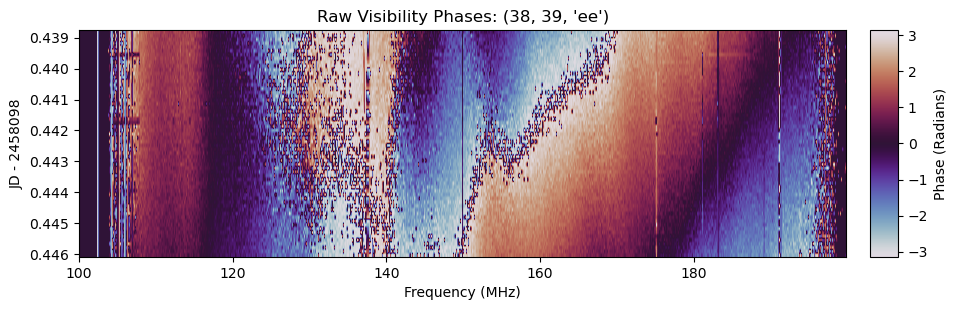

In [8]:
plot_vis(data, flags, hd, JD, bl, 'phase', title='Raw Visibility Phases')

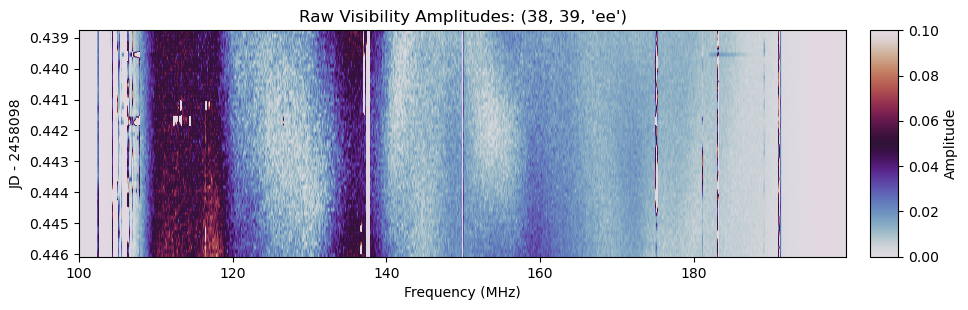

In [9]:
plot_vis(data, flags, hd, JD, bl, 'amp', title='Raw Visibility Amplitudes')

### Redundant calibration

In [10]:
# load firstcal gains and flags
firstcal_fn = raw_data_fn.replace('uvh5', 'first.calfits')
firstcal_file = os.path.join(analysis_folder, firstcal_fn)
hc = HERACal(firstcal_file)
fc_gains, fc_flags, _, _ = hc.read()

In [11]:
bad_ants_file = os.path.join(hera_pkgs, 'hera_opm/pipelines/h1c/idr2/v2/bad_ants/{}.txt'.format(int(JD)))

bad_ants = np.loadtxt(bad_ants_file).astype(int)
print('Bad antennas for JD {} are: {}'.format(int(JD), list(bad_ants)))

Bad antennas for JD 2458098 are: [0, 2, 11, 24, 50, 53, 54, 67, 69, 98, 122, 136, 139]


In [12]:
omni_vis_fn = raw_data_fn.replace('uvh5', 'omni_vis.uvh5')
omni_vis_file = os.path.join(analysis_folder, omni_vis_fn)

if not os.path.exists(omni_vis_file):
    print('Running REDCAL on raw visibility file')
    ant_z_thresh = 4.0
    solar_horizon = 0.0
    nInt_to_load = 8
    flag_nchan_low = 50
    flag_nchan_high = 50
    min_bl_cut = 15
    max_bl_cut = 90
    ex_ants = bad_ants
    outdir = working_dir

    redcal_run(raw_data_file, filetype='uvh5', firstcal_ext='.first.calfits', omnical_ext='.omni.calfits',
            omnivis_ext='.omni_vis.uvh5', iter0_prefix='', outdir=outdir, ant_metrics_file=None, clobber=True, 
            nInt_to_load=nInt_to_load, pol_mode='2pol', bl_error_tol=1.0, ex_ants=ex_ants, ant_z_thresh=ant_z_thresh, 
            max_rerun=5, solar_horizon=solar_horizon, flag_nchan_low=flag_nchan_low, flag_nchan_high=flag_nchan_high, 
            fc_conv_crit=1e-6, fc_maxiter=50, oc_conv_crit=1e-10, oc_maxiter=500, check_every=10, check_after=50, gain=.4, 
            add_to_history='', verbose=True, min_bl_cut=min_bl_cut, max_bl_cut=max_bl_cut)
else:
    print('REDCAL omni calibrated file already exists')

REDCAL omni calibrated file already exists


In [13]:
hd = HERAData(omni_vis_file)

In [14]:
# recall that at this stage, after redcal, all baselines of the same type are aggregated into baseline groups
# with the baseline group nameed after the first baseline in that group type
reds = get_reds(hd.antpos, pols=['ee'])
red_dict = {bl: bl_group[0] for bl_group in reds for bl in bl_group}
bl_red = red_dict[bl]
print('Baseline {} corresponds to redundant baseline group of type {}'.format(bl, bl_red))

Baseline (38, 39, 'ee') corresponds to redundant baseline group of type (0, 1, 'ee')


In [15]:
selected_bls = [bl for bl, red_bl in red_dict.items() if red_bl == bl_red]
selected_bls_flagged = [bl for bl in selected_bls if not any(j in bad_ants for j in bl[:2])]

In [16]:
# load redundant baseline of type bl_red
redcal_data, redcal_flags, redcal_nsamples = hd.read(bls=bl_red)

invalid value encountered in true_divide


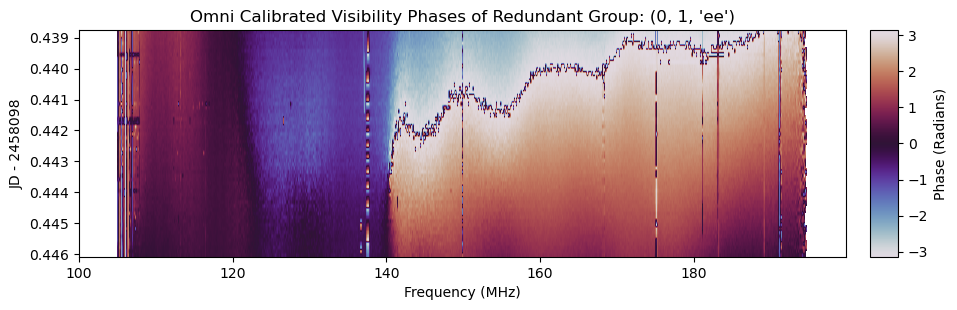

In [17]:
plot_vis(redcal_data, redcal_flags, hd, JD, bl_red, 'phase', \
         title='Omni Calibrated Visibility Phases of Redundant Group')

divide by zero encountered in true_divide


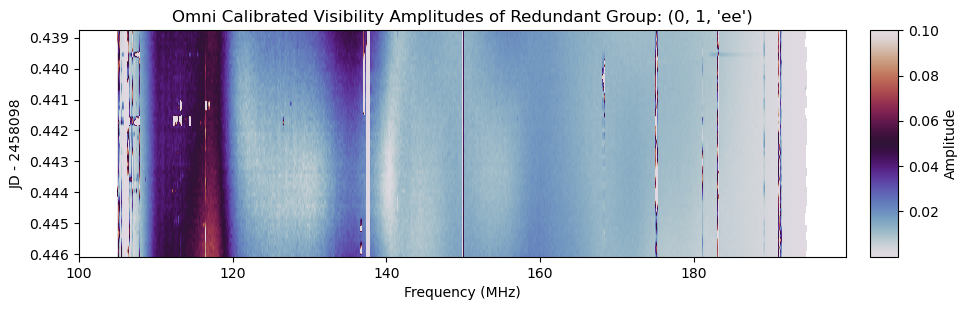

In [18]:
plot_vis(redcal_data, redcal_flags, hd, JD, bl_red, 'amp', \
         title='Omni Calibrated Visibility Amplitudes of Redundant Group')

### Reading omni_cal calfits file to check antenna gains after omni_cal

In [19]:
# load redundant calibration gains, flags, chi^2 per antenna, and chi^2 / DoF
omni_calfits_fn = raw_data_fn.replace('uvh5', 'omni.calfits')
omni_calfits_file = os.path.join(analysis_folder, omni_calfits_fn)
hc = HERACal(omni_calfits_file)
oc_gains, oc_flags, oc_quals, oc_total_quals = hc.read()

In [20]:
ant = split_bl(bl)[0]

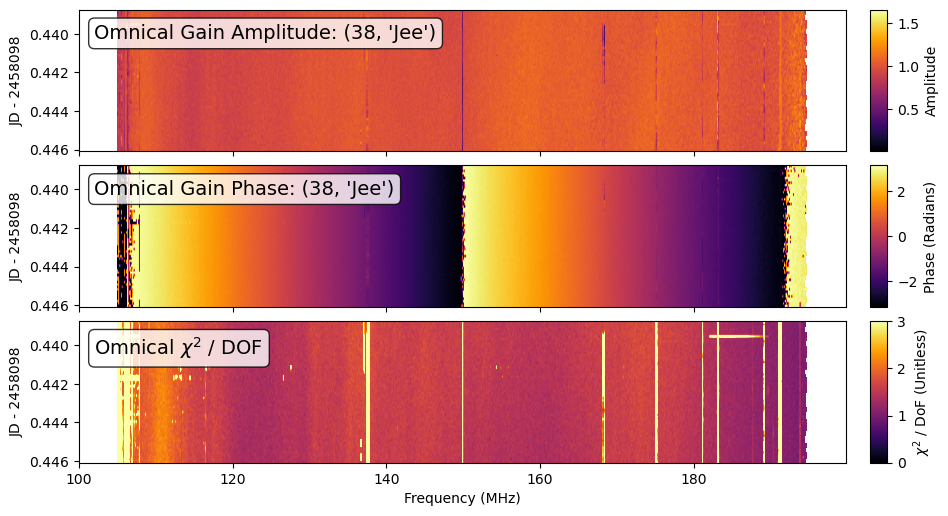

In [21]:
wc_ylabel = 'JD - {}'.format(int(JD))
waterfall_column([np.absolute(oc_gains[ant]), np.angle(oc_gains[ant]), oc_total_quals[ant[1]]],
                 [oc_flags[ant], oc_flags[ant], oc_flags[ant]],
                 ['Omnical Gain Amplitude: {}'.format(ant), 'Omnical Gain Phase: {}'.format(ant), 'Omnical $\chi^2$ / DOF'],
                 wc_ylabel,
                 clims=[None, None, [0, 3]],
                 clabels=['Amplitude', 'Phase (Radians)', '$\chi^2$ / DoF (Unitless)'],
                 cmaps = ['inferno', 'inferno', 'inferno'],
                 extents=[hc.freqs[0] / 1e6, hc.freqs[-1] / 1e6, hc.times[-1] -int(JD), hc.times[0]-int(JD)])

In [22]:
# Applying omni_cal solutions to the data?

### Absolute calibration

In [23]:
# Apply calibration solution to data

In [24]:
# Load abscal calibration solutions
abs_calfits_fn = raw_data_fn.replace('uvh5', 'abs.calfits')
abs_calfits_file = os.path.join(analysis_folder, abs_calfits_fn)
hc = HERACal(abs_calfits_file)
ac_gains, ac_flags, ac_quals, ac_total_quals = hc.read()

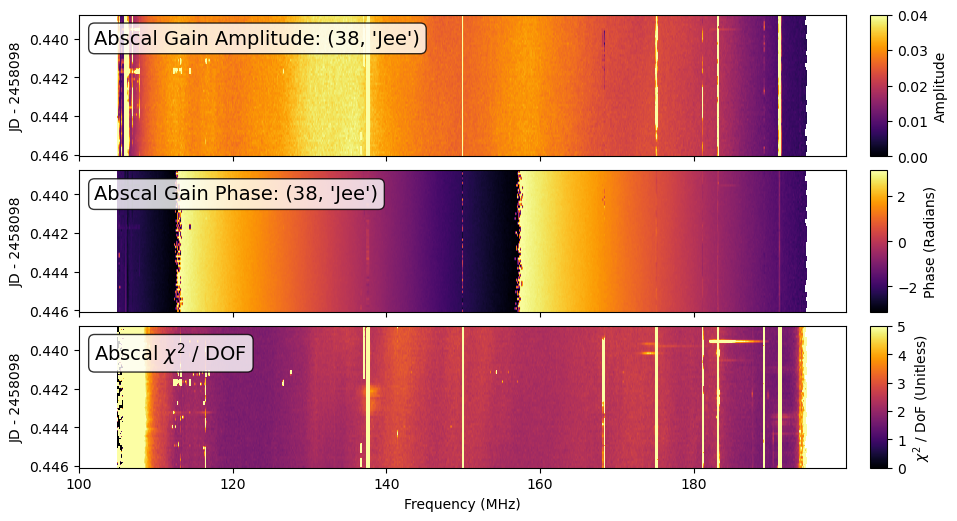

In [25]:
waterfall_column([np.absolute(ac_gains[ant]), np.angle(ac_gains[ant]), ac_total_quals[ant[1]]],
                 [ac_flags[ant], ac_flags[ant], ac_flags[ant]],
                 ['Abscal Gain Amplitude: {}'.format(ant), 'Abscal Gain Phase: {}'.format(ant), 'Abscal $\chi^2$ / DOF'],
                 wc_ylabel,
                 clims=[[0, .04], None, [0, 5]],
                 clabels=['Amplitude', 'Phase (Radians)', '$\chi^2$ / DoF (Unitless)'],
                 cmaps = ['inferno', 'inferno', 'inferno'],
                 extents=[hc.freqs[0] / 1e6, hc.freqs[-1] / 1e6, hc.times[-1] -int(JD), hc.times[0]-int(JD)])

In [26]:
# Apply abscal calibration to data
abscal_data, abscal_flags = deepcopy(data), deepcopy(flags)
calibrate_in_place(abscal_data, ac_gains, data_flags=abscal_flags, cal_flags=ac_flags)

In [27]:
# Find corresponding LSTs in the externally calibrated Abscal Model
model_dir = '/lustre/aoc/projects/hera/nkern/idr3_abscal_models/full_model/' # at NRAO
if not os.path.exists(model_dir):
    model_dir = analysis_folder # local copy

model_files = glob.glob(os.path.join(model_dir, 'zen.2458042.*.HH.uvRXLS.uvh5')) # cheatingly slightly by only checking the .5* files
matched_model_files = sorted(set(match_times(raw_data_file, model_files, filetype='uvh5')))
hdm = HERAData(matched_model_files)
model, model_flags, _ = hdm.read(bls=[bl])

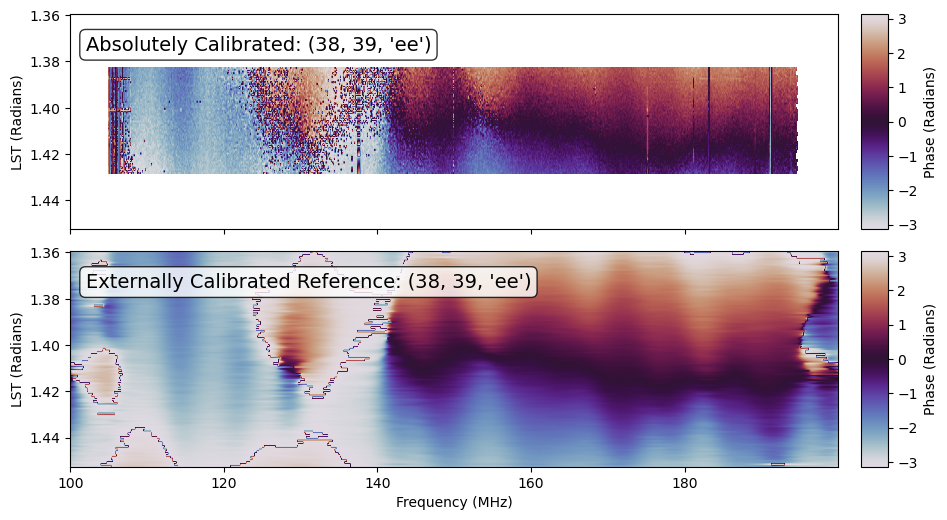

In [28]:
# compare redundantly + absolutely calibrated data to model
waterfall_column([np.angle(abscal_data[bl]), np.angle(model[bl])],
                 [abscal_flags[bl], model_flags[bl]],
                 ['Absolutely Calibrated: {}'.format(bl), 'Externally Calibrated Reference: {}'.format(bl)],
                 'LST (Radians)',
                 clabels=['Phase (Radians)', 'Phase (Radians)'],
                 cmaps = ['twilight', 'twilight'],  
                 ylims = [[model.lsts[-1], model.lsts[0]], None],
                 extents=[[hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [model.freqs[0] / 1e6, model.freqs[-1] / 1e6, model.lsts[-1], model.lsts[0]]])

### RFI Flagging

In [29]:
# load flagged calibration solutions
flagged_abscal_fn = raw_data_fn.replace('uvh5', 'flagged_abs.calfits')
flagged_abscal_file = os.path.join(analysis_folder, flagged_abscal_fn)
hc = HERACal(flagged_abscal_file)
fac_gains, fac_flags, fac_quals, fac_total_quals = hc.read()

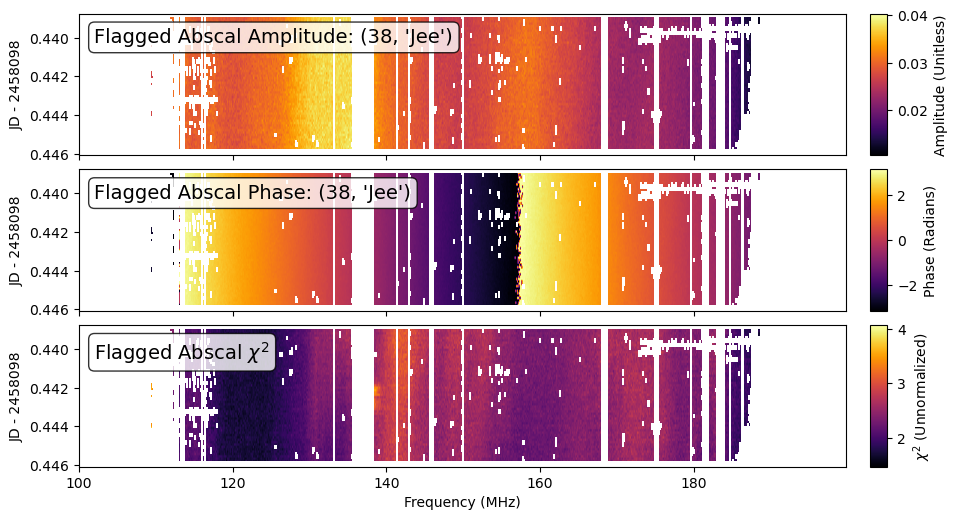

In [30]:
waterfall_column([np.abs(fac_gains[ant]), np.angle(fac_gains[ant]), fac_total_quals[ant[1]]],
                 [fac_flags[ant], fac_flags[ant], fac_flags[ant]],
                 ['Flagged Abscal Amplitude: {}'.format(ant), 
                  'Flagged Abscal Phase: {}'.format(ant), 
                  'Flagged Abscal $\chi^2$'],
                 wc_ylabel,
                 clabels=['Amplitude (Unitless)', 'Phase (Radians)', '$\chi^2$ (Unnormalized)'],
                 cmaps = ['inferno', 'inferno', 'inferno'],
                 extents=[hc.freqs[0] / 1e6, hc.freqs[-1] / 1e6, hc.times[-1] - int(JD), hc.times[0] - int(JD)])

In [31]:
# applying these calibration solutions and flags to the data to get visibilities for the baseline
# specified at the start of the notebook

# Applying abscal (+ redcal) + RFI flagged calibration to data
flagged_abscal_data, flagged_abscal_flags = deepcopy(data), deepcopy(flags)
calibrate_in_place(flagged_abscal_data, fac_gains, data_flags=flagged_abscal_flags, cal_flags=fac_flags)

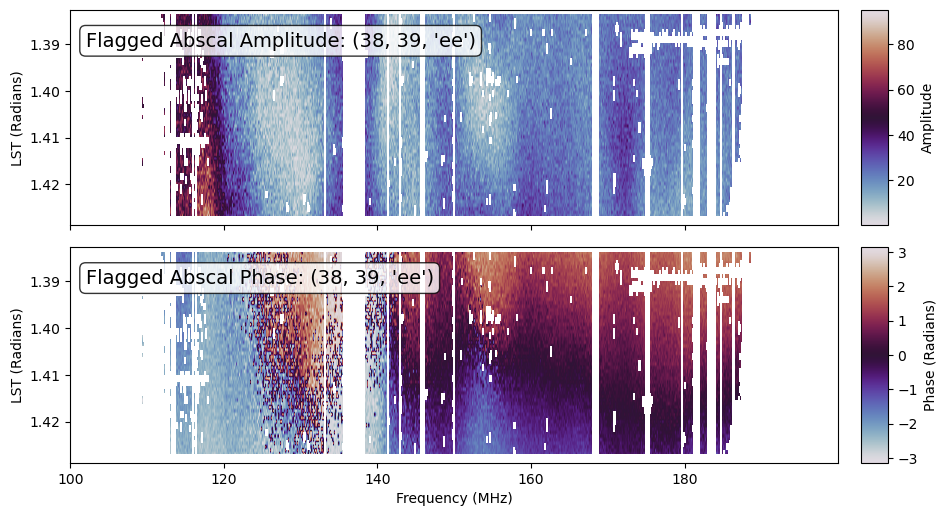

In [32]:
waterfall_column([np.absolute(flagged_abscal_data[bl]), np.angle(flagged_abscal_data[bl])],
                 [flagged_abscal_flags[bl], flagged_abscal_flags[bl]],
                 ['Flagged Abscal Amplitude: {}'.format(bl), 'Flagged Abscal Phase: {}'.format(bl)],
                 'LST (Radians)',
                 clabels=['Amplitude', 'Phase (Radians)'],
                 cmaps = ['twilight', 'twilight'],             
                 extents=[[hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]]])

### Calibration smoothing

In [33]:
# load flagged calibration solutions
smoothcal_fn = raw_data_fn.replace('uvh5', 'flagged_abs.calfits')
smoothcal_file = os.path.join(analysis_folder, smoothcal_fn)
hc = HERACal(smoothcal_file)
sac_gains, sac_flags, sac_quals, sac_total_quals = hc.read()

In [34]:
# find antenna that was picked as the reference by looking for unflagged antennas with 0 phase
sc_refant = {pol: sorted([(np.mean(np.abs(np.angle(sac_gains[ant]))), ant) 
                          for ant in sac_gains if ant[1]==pol and not np.all(sac_flags[ant])])[0][1]
                          for pol in hc.pols}
for pol in hc.pols:
    print('Antenna {} chosen as the reference for {}.'.format(sc_refant[pol][0], pol))

Antenna 39 chosen as the reference for Jee.
Antenna 52 chosen as the reference for Jnn.


In [35]:
# rephase abscal to to have the same reference antenna as smooth_cal
rephased_abscal = fac_gains[ant] * np.abs(fac_gains[sc_refant[ant[1]]]) / fac_gains[sc_refant[ant[1]]]
smoothcal_gains = deepcopy(sac_gains[ant])

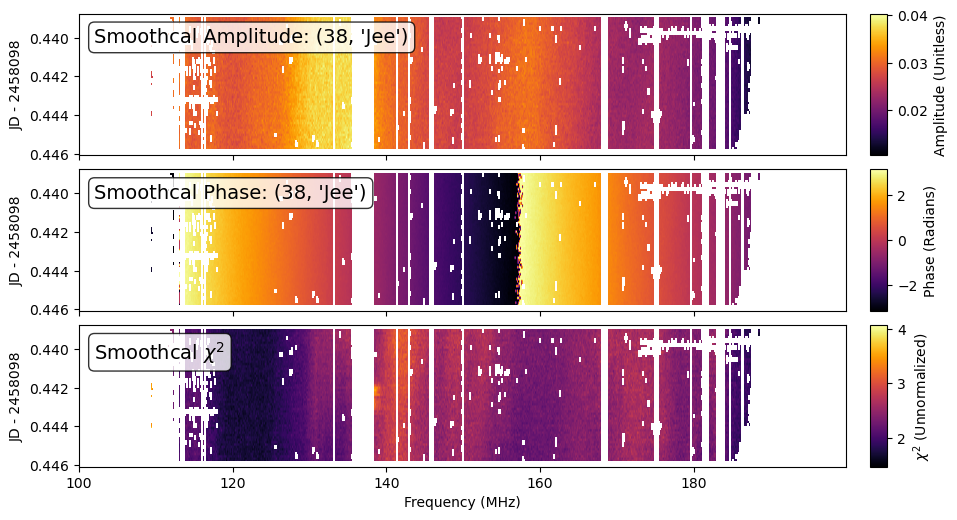

In [36]:
waterfall_column([np.abs(smoothcal_gains), np.angle(smoothcal_gains), sac_total_quals[ant[1]]],
                 [sac_flags[ant], sac_flags[ant], sac_flags[ant]],
                 ['Smoothcal Amplitude: {}'.format(ant), 
                  'Smoothcal Phase: {}'.format(ant), 
                  'Smoothcal $\chi^2$'],
                 wc_ylabel,
                 clabels=['Amplitude (Unitless)', 'Phase (Radians)', '$\chi^2$ (Unnormalized)'],
                 cmaps = ['inferno', 'inferno', 'inferno'],
                 extents=[hc.freqs[0] / 1e6, hc.freqs[-1] / 1e6, hc.times[-1] - int(JD), hc.times[0] - int(JD)])

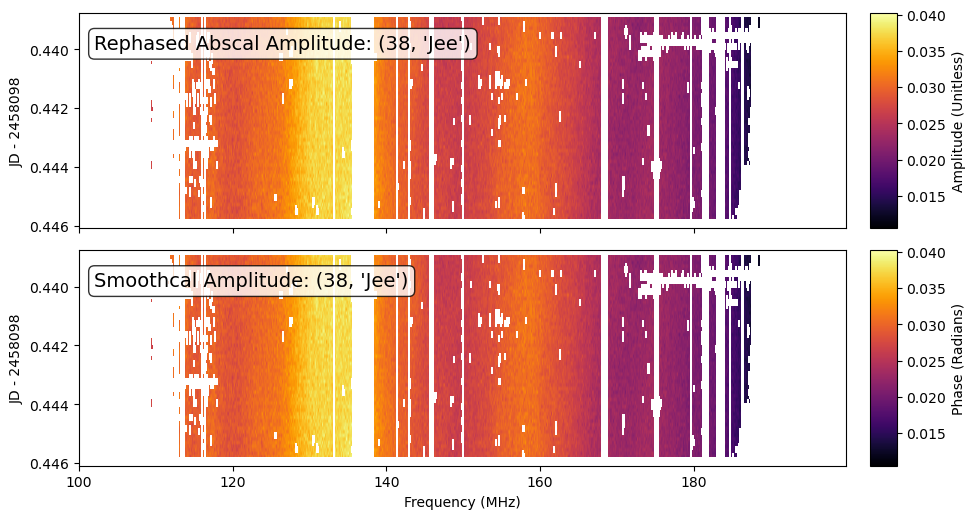

In [37]:
# Comparing to abscal
waterfall_column([np.abs(rephased_abscal), np.abs(smoothcal_gains)],
                 [fac_flags[ant], sac_flags[ant]],
                 ['Rephased Abscal Amplitude: {}'.format(ant), 
                  'Smoothcal Amplitude: {}'.format(ant)],
                 wc_ylabel,
                 clabels=['Amplitude (Unitless)', 'Phase (Radians)'],
                 cmaps = ['inferno', 'inferno'],
                 extents=[hc.freqs[0] / 1e6, hc.freqs[-1] / 1e6, hc.times[-1] - int(JD), hc.times[0] - int(JD)])

In [38]:
# Applying smoothcal to data
smoothcal_data, smoothcal_flags = deepcopy(data), deepcopy(flags)
calibrate_in_place(smoothcal_data, sac_gains, data_flags=smoothcal_flags, cal_flags=sac_flags)

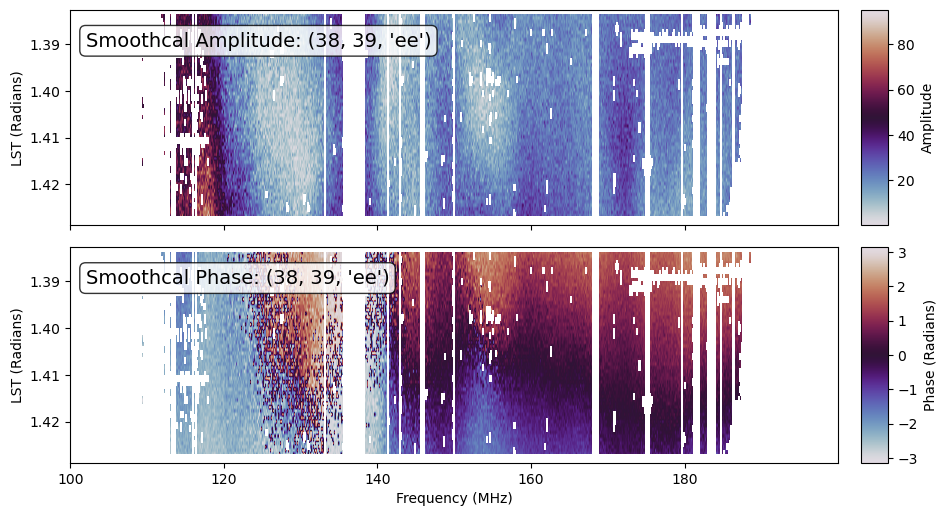

In [39]:
waterfall_column([np.absolute(smoothcal_data[bl]), np.angle(smoothcal_data[bl])],
                 [smoothcal_flags[bl], smoothcal_flags[bl]],
                 ['Smoothcal Amplitude: {}'.format(bl), 'Smoothcal Phase: {}'.format(bl)],
                 'LST (Radians)',
                 clabels=['Amplitude', 'Phase (Radians)'],
                 cmaps = ['twilight', 'twilight'],             
                 extents=[[hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]]])

### Delay filtering

In [40]:
delay_filtered_fn = raw_data_fn.replace('uvh5', 'OCRSD.uvh5')
delay_filtered_file = os.path.join(analysis_folder, delay_filtered_fn)
hd_dfil = HERAData(delay_filtered_file)
dfil_data, dfil_flags, _ = hd_dfil.read(bls=[bl])

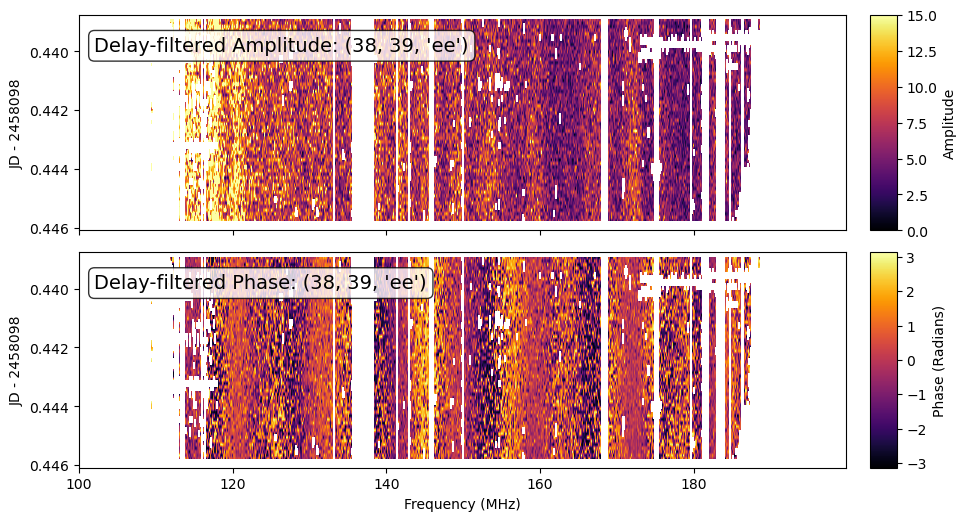

In [41]:
waterfall_column([np.absolute(dfil_data[bl]), np.angle(dfil_data[bl])],
                 [dfil_flags[bl], dfil_flags[bl]],
                 ['Delay-filtered Amplitude: {}'.format(bl), 
                  'Delay-filtered Phase: {}'.format(bl)],
                 wc_ylabel,
                 clabels=['Amplitude', 'Phase (Radians)'],
                 cmaps = ['inferno', 'inferno'],
                 clims=[[0, 15], None],
                 extents=[hc.freqs[0] / 1e6, hc.freqs[-1] / 1e6, hc.times[-1] - int(JD), hc.times[0] - int(JD)])

### LST Binning

In [42]:
# Find corresponding LSTs in the externally calibrated Abscal Model
lstbin_dir = '/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/LSTBIN/one_group/grp1' # at NRAO
if not os.path.exists(lstbin_dir):
    lstbin_dir = analysis_folder # local copy

lstbinned_file = os.path.join(lstbin_dir, 'zen.grp1.of1.LST.1.40949.HH.OCRSL.uvh5')
hd_lst = HERAData(lstbinned_file)
lst_data, lst_flags, lst_nsamples = hd_lst.read(bls=[bl])

antenna_diameters is not set. Using known values for HERA.


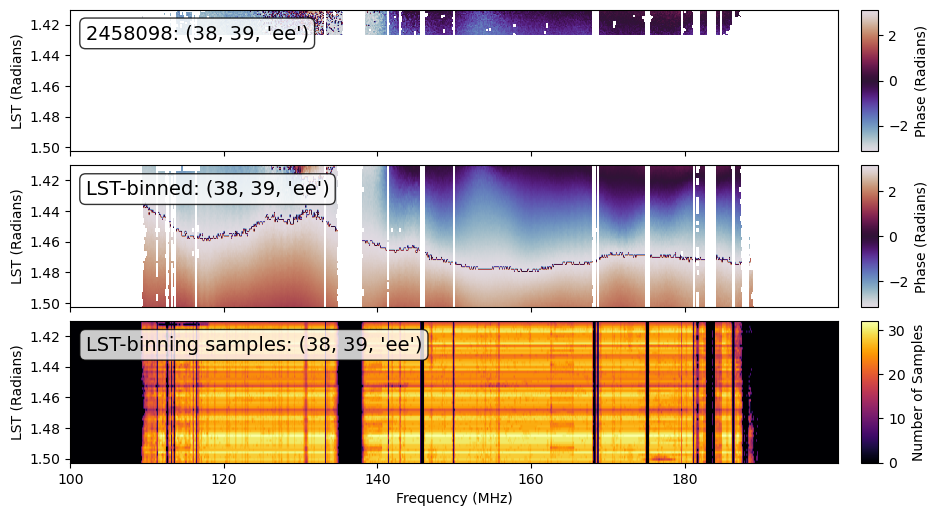

In [43]:
# compare redundantly and then absolutely calibrated data to externally calibrated reference
waterfall_column([np.angle(smoothcal_data[bl]), np.angle(lst_data[bl]), lst_nsamples[bl]],
                 [smoothcal_flags[bl], lst_flags[bl], np.zeros_like(lst_flags[bl])],
                 ['2458098: {}'.format(bl), 'LST-binned: {}'.format(bl), 'LST-binning samples: {}'.format(bl)],
                 'LST (Radians)',
                 clabels=['Phase (Radians)', 'Phase (Radians)', 'Number of Samples'],
                 cmaps = ['twilight', 'twilight', 'inferno'],
                 ylims = [[hd_lst.lsts[-1], hd_lst.lsts[0]], None, None],                 
                 extents=[[hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]], 
                          [hd_lst.freqs[0] / 1e6, hd_lst.freqs[-1] / 1e6, hd_lst.lsts[-1], hd_lst.lsts[0]],
                          [hd_lst.freqs[0] / 1e6, hd_lst.freqs[-1] / 1e6, hd_lst.lsts[-1], hd_lst.lsts[0]]])

### Comparing all visibility products

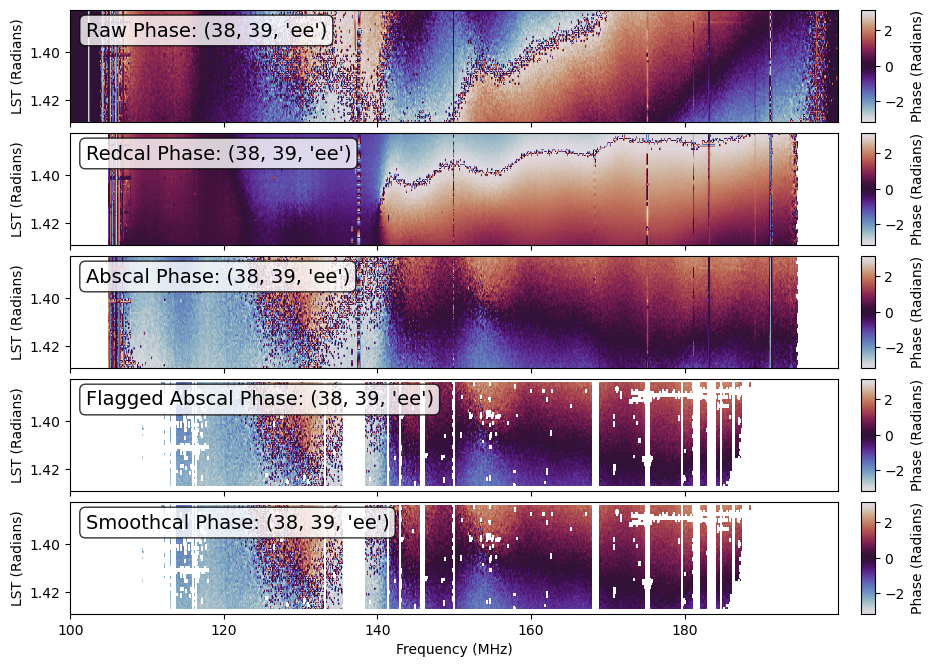

In [44]:
waterfall_column([np.angle(data[bl]), np.angle(redcal_data[bl_red]), np.angle(abscal_data[bl]), np.angle(flagged_abscal_data[bl]), np.angle(smoothcal_data[bl])],
                 [flags[bl], redcal_flags[bl_red], abscal_flags[bl], flagged_abscal_flags[bl], smoothcal_flags[bl]],
                 ['Raw Phase: {}'.format(bl), 'Redcal Phase: {}'.format(bl), 'Abscal Phase: {}'.format(bl), 'Flagged Abscal Phase: {}'.format(bl), 'Smoothcal Phase: {}'.format(bl)],
                 'LST (Radians)',
                 clabels=['Phase (Radians)', 'Phase (Radians)', 'Phase (Radians)', 'Phase (Radians)', 'Phase (Radians)'],
                 cmaps = ['twilight', 'twilight', 'twilight', 'twilight', 'twilight'],
                 extents=[[hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]]],
                 figsize=(12,8))

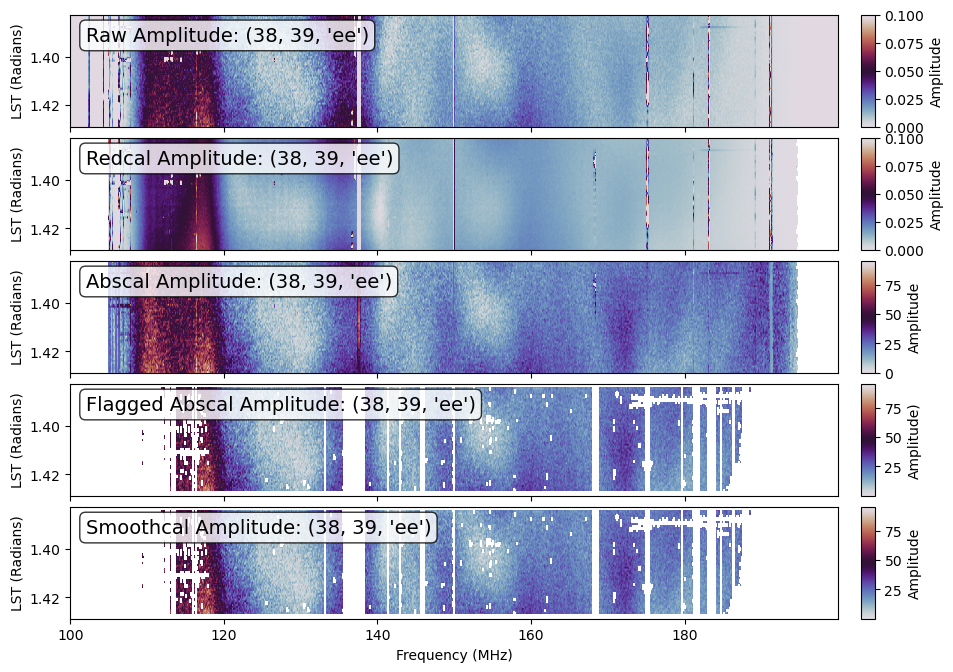

In [45]:
max_smoothcal_value = np.max(np.absolute((flagged_abscal_data[bl][~flagged_abscal_flags[bl]])))

waterfall_column([np.absolute(data[bl]), np.absolute(redcal_data[bl_red]), np.absolute(abscal_data[bl]), np.absolute(flagged_abscal_data[bl]), np.absolute(smoothcal_data[bl])],
                 [flags[bl], redcal_flags[bl_red], abscal_flags[bl], flagged_abscal_flags[bl], smoothcal_flags[bl]],
                 ['Raw Amplitude: {}'.format(bl), 'Redcal Amplitude: {}'.format(bl), 'Abscal Amplitude: {}'.format(bl), 'Flagged Abscal Amplitude: {}'.format(bl), 'Smoothcal Amplitude: {}'.format(bl)],
                 'LST (Radians)',
                 clabels=['Amplitude', 'Amplitude', 'Amplitude', 'Amplitude)', 'Amplitude'],
                 cmaps = ['twilight', 'twilight', 'twilight', 'twilight', 'twilight'],
                 clims=[[0, .1], [0, .1], [0, max_smoothcal_value], None, None],
                 extents=[[hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]],
                          [hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]]],
                 figsize=(12,8))